# Session analysis

In [1]:
from mna.sessions.eye_session import process_session_eye
from mna.sessions.eeg_session import process_session_eeg
from mna.sessions.motor_session import process_session_motor
from mna.sessions.ecg_session import process_session_ecg

# 1. Read a RN App, converted pkl file, and create the metadata and data structure

In [2]:
from os import listdir
from os.path import isfile, join
from mna.utils.rnapp_data_format import read_all_lslpresets, return_metadata_from_name, event_data_from_data
import pickle

In [3]:
data_dir = "/Volumes/GoogleDrive/My Drive/Research Work/BCIFlow/Pkl_Recordings/"
lsl_dir = "../mna/LSLPresets/"
onlyfiles = [f for f in listdir(data_dir) if isfile(join(data_dir, f)) and '.pkl' in f]
input_path = data_dir + onlyfiles[4] # pick a random file
print(f"input_path {input_path}")
metadata_jsons = read_all_lslpresets(path_to_jsonfiles=lsl_dir)
with open(input_path, 'rb') as handle:
    rns_data = pickle.load(handle)
    
## Add metadata to data

for key in rns_data.keys():
    rns_data[key].append(return_metadata_from_name(key, metadata_jsons))

input_path /Volumes/GoogleDrive/My Drive/Research Work/BCIFlow/Pkl_Recordings/06_15_2022_10_38_35-Exp_myexperiment-Sbj_02-Ssn_02.dats.pkl


# 2. Create new events (trial start etc.)

In [4]:
event_df = event_data_from_data(rns_data)
event_df['trial_damage'] = event_df.damage.diff().fillna(0)
event_df['trial_duration'] = event_df.trial_end_time - event_df.trial_start_time
percent_missing = event_df.notnull().sum() / len(event_df)
summary_statistics = {}
summary_statistics['voice_success_rate'] = percent_missing['voice_timestamp']
if 'chunk_timestamp' in percent_missing:
    summary_statistics['chunk_success_rate'] = percent_missing['chunk_timestamp']
else:
    summary_statistics['chunk_success_rate'] = 0

# temporary fix for pilot phase where we had some incomplete data
if 'block_condition' not in event_df:
    event_df['block_condition'] = 'practice'
    event_df.loc[5:,'block_condition'] = 'voice'
summary_statistics['trial_count'] = (event_df.block_condition!='practice').sum()
summary_statistics['hard_trials_rate'] = (event_df.spoken_difficulty=='hard').sum()/event_df.spoken_difficulty.notnull().sum()

# extra
#event_df.spoken_difficulty = event_df.spoken_difficulty.replace({'easy': 0, 'hard': 1})
#event_df[event_df.trial_duration<1000].plot.scatter(x='trial_duration', y='spoken_difficulty')


# 3. ECG Data Processing

In [5]:
post_processed_event_df = process_session_ecg(rns_data, event_df,plot_frequency=20,plot_ecg_snippet=40)

# 4. Eye Tracking Processing

In [6]:
post_processed_event_df = process_session_eye(rns_data, post_processed_event_df,detect_blink=True,plot_frequency=20, plot_eye_snippet=40)

Computed velocity exceeds threshold. Inappropriate filter setup? [2087.7 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2566.9 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1798.8 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1811.1 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1711.0 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1991.5 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1886.0 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1862.0 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1512.8 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1002.0 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1054.9 > 1000.0 deg/s]
Computed velocity exc

x_deg 0        -5.975909
1        -6.048771
2        -6.081030
3        -6.086060
4        -6.104467
           ...    
11793   -10.334776
11794   -10.245796
11795   -10.237527
11796   -10.249709
11797   -10.248507
Name: x_deg, Length: 11798, dtype: float64
y_deg 0        11.038289
1        11.056701
2        11.058238
3        11.042203
4        11.022884
           ...    
11793   -10.938564
11794   -10.874929
11795   -10.842198
11796   -10.801079
11797   -10.846188
Name: y_deg, Length: 11798, dtype: float64
timestamp 0        2436.047210
1        2436.055541
2        2436.063872
3        2436.072203
4        2436.080534
            ...     
11793    2534.302140
11794    2534.310471
11795    2534.318803
11796    2534.327135
11797    2534.335467
Name: timestamp, Length: 11798, dtype: float64
x_deg 0      -10.244583
1      -10.307235
2      -10.169266
3       -9.940211
4       -9.957689
          ...    
1527     0.304809
1528     0.277384
1529     0.496254
1530     0.624556
1531     0


KeyboardInterrupt



# 5. EEG

Creating RawArray with float64 data, n_channels=89, n_times=3422634
    Range : 0 ... 3422633 =      0.000 ...  1671.208 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 67585 samples (33.000 sec)

Not setting metadata
42 matching events found
Setting baseline interval to [-0.2001953125, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from pr

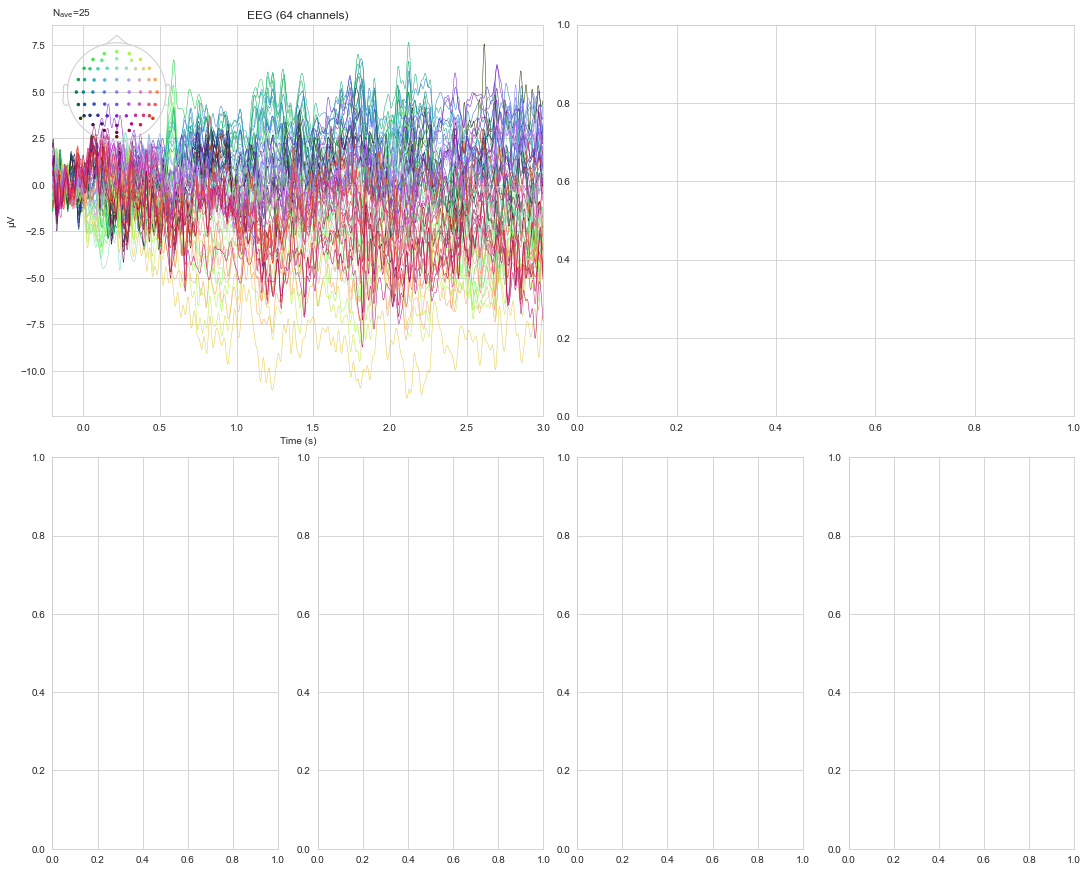

    Using multitaper spectrum estimation with 7 DPSS windows


/Users/sharathckoo/opt/miniconda3/envs/py39/lib/python3.8/site-packages/mne/viz/topomap.py:244: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(im, cax=cax, format=format)
/Users/sharathckoo/opt/miniconda3/envs/py39/lib/python3.8/site-packages/mne/viz/topomap.py:244: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(im, cax=cax, format=format)


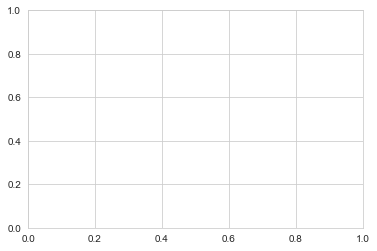

    Using multitaper spectrum estimation with 7 DPSS windows


/Users/sharathckoo/opt/miniconda3/envs/py39/lib/python3.8/site-packages/mne/viz/topomap.py:244: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(im, cax=cax, format=format)
/Users/sharathckoo/opt/miniconda3/envs/py39/lib/python3.8/site-packages/mne/viz/topomap.py:244: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(im, cax=cax, format=format)


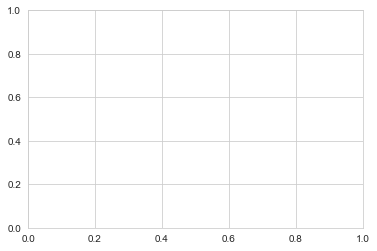

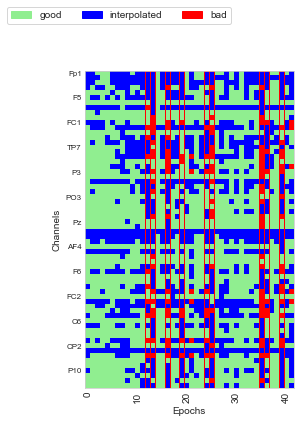

In [7]:
post_processed_event_df, epochs, events, event_dict, info, reject_log, ica = process_session_eeg(rns_data, post_processed_event_df,
                                                                    run_autoreject=True, run_ica=True)

# 5. Motor

In [8]:
post_processed_event_df = process_session_motor(rns_data, post_processed_event_df, motor_channel='Unity_MotorInput',
                                                plot_motor_result = True, plot_motor_snippet = 30, plot_frequency = 10)


# 5. Save

In [9]:
post_processed_event_df.to_csv(f"../output/ppid_{post_processed_event_df.iloc[0].ppid}_session_{post_processed_event_df.iloc[0].session}.csv")